# Modeling

This notebook will be used for modeling.

# Libraries

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import time
import seaborn as sns
import numpy as np
# from pandasql import sqldf
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import glob
# import matplotlib.pyplot as plt
# import math
# import statsmodels.api as sm

# Functions

In [19]:
class model():
    
    '''
    The class is used to repeat the standard tasks associated with the model
    '''
    
    def __init__(self, modelType, df, scaler):
        
        '''
        Initialize the model, defines X and y, split train and test
        
        modelType - defines the model class
        df - the data frame
        scaler - scaler that will be used
        '''
        
        # Define the target
        self.y = df['goals_total']

        # Define the features
        self.X = df.drop(['goals_total'], axis=1)
        
        # Split train and test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=7)
        
        # Scale
        if scaler is not None:
            self.X_train = scaler.fit_transform(self.X_train)
            self.X_test = scaler.transform(self.X_test)

        self.modelType = modelType
    
    def fit(self):
        
        '''
        Fit the model
        '''
    
        startTime = time.time()
        self.modelType.fit(self.X_train, self.y_train)
        self.learnTime = round(time.time() - startTime, 4)
        
    def predict(self):
        
        '''
        Predict using the model
        '''
        
        startTime = time.time()
        model_prediction_train = self.modelType.predict(self.X_train)
        model_prediction_test = self.modelType.predict(self.X_test)
        self.predictTime = round(time.time() - startTime, 4)
        
    def score(self, type):
        
        '''
        Returns the score
        
        type - either train or test
        '''
        
        if type == 'train':
            return round(self.modelType.score(self.X_train, self.y_train), 4)
        else:
            return round(self.modelType.score(self.X_test, self.y_test), 4)
        
    def save(self, model, version, scale, featureE, hyper, featureS):
        
        '''
        Adds parameters of each iteration into the summary data frame

        model - model type
        version - version of model/iteration
        scale - scaling
        featureE - feature engineering
        hyper - hyper-parameters tuning
        featureS - feature selection
        '''
        
        dfModelSummary.loc[dfModelSummary.index[0], model + ' ' + version] = dfFootballML.shape[1] - 1

        dfModelSummary.loc[dfModelSummary.index[1], model + ' ' + version] = scale

        dfModelSummary.loc[dfModelSummary.index[2], model + ' ' + version] = featureE

        dfModelSummary.loc[dfModelSummary.index[3], model + ' ' + version] = hyper

        dfModelSummary.loc[dfModelSummary.index[4], model + ' ' + version] = featureS
        
        dfModelSummary.loc[dfModelSummary.index[5], model + ' ' + version] = round(self.modelType.score(self.X_train, self.y_train), 4)
        dfModelSummary.loc[dfModelSummary.index[6], model + ' ' + version] = round(self.modelType.score(self.X_test, self.y_test), 4)
        
        dfModelSummary.loc[dfModelSummary.index[7], model + ' ' + version] = self.learnTime
        dfModelSummary.loc[dfModelSummary.index[8], model + ' ' + version] = self.predictTime
        
    def coef(self):
        return self.modelType.coef_

# Initialization

In [3]:
# Display all columns
pd.set_option('display.max_columns', None)

# Intialize the summary data frame
indexSummary = ['Number of features','Scaling','Feature enginnering','Hyper-parameters tuning','Feature selection',\
                'Train score','Test score','Learning time','Prediction time','Other changes']

dfModelSummary = pd.DataFrame(index=indexSummary)

# Load from files

In [4]:
dfFootballML = pd.read_csv('data/football_ml.csv')
dfFootballMLBench = pd.read_csv('data/football_ml_bench.csv')

# Feature selection

## Variance

I will check the variance for each feature and remove the features with variance below the threshold.

Total number of features: 24
Number of features that should be removed: 0
The list of features that should be removed: []


[Text(0.5, 0, 'Variance'),
 Text(0.5, 1.0, 'MinMax Scaled variances comparison')]

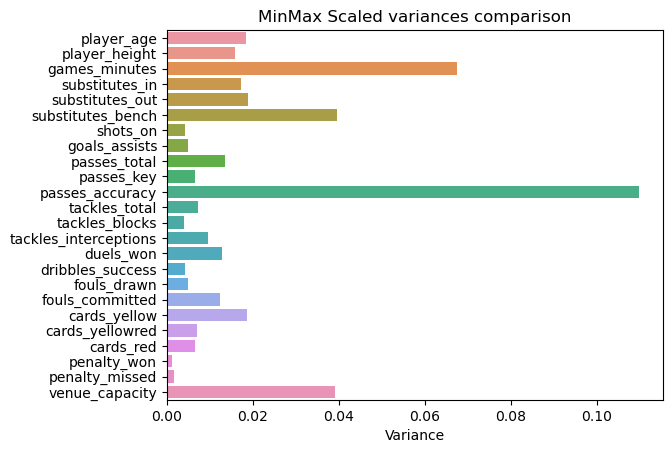

In [5]:
scaler = MinMaxScaler()

# List of features
X = dfFootballML.drop('goals_total', axis=1)

# Scale the data frame
XScaled = scaler.fit_transform(X)

# Define the variance threshold
VarThresh = VarianceThreshold(threshold=0.0004)

# Fit the threshold on the scaled data
VarThresh.fit(XScaled)

print(f'Total number of features: {len(X.columns)}')
print(f'Number of features that should be removed: {len(X.columns[~VarThresh.get_support()])}')
print(f'The list of features that should be removed: {X.columns[~VarThresh.get_support()].to_list()}')

sns.barplot(y=X.columns, x=VarThresh.variances_).set(xlabel='Variance', title='MinMax Scaled variances comparison')

All features passed the test, we do not need to remove any feature.

# Transformation

## One hot encoding

### Venue surface

It will be a binary encoding, grass or not.

In [6]:
# Initialize binary OHE
ohe = OneHotEncoder(handle_unknown='ignore', drop='if_binary')

# Encode the column
encoded = ohe.fit_transform(dfFootballMLBench[['venue_surface']])

# Create a data frame
dfOHE = pd.DataFrame(encoded.toarray(), columns=['venue_surface'])

# Concatenate the encoded column to the original data frame
dfFootballML = pd.concat([dfFootballML, dfOHE], axis=1)

# Remove from the bench
dfFootballMLBench = dfFootballMLBench.drop('venue_surface', axis=1)

### Player nationality

There are 171 nationalities. Some of them have 1 or low number of records. One Hot Encoding will create a new feature for each column. I want to cover the majority of data and also want to reduce the number of categories. I will find the minimum frequency to cover 80% of the data.

[Text(0.5, 1.0, 'Player Nationality')]

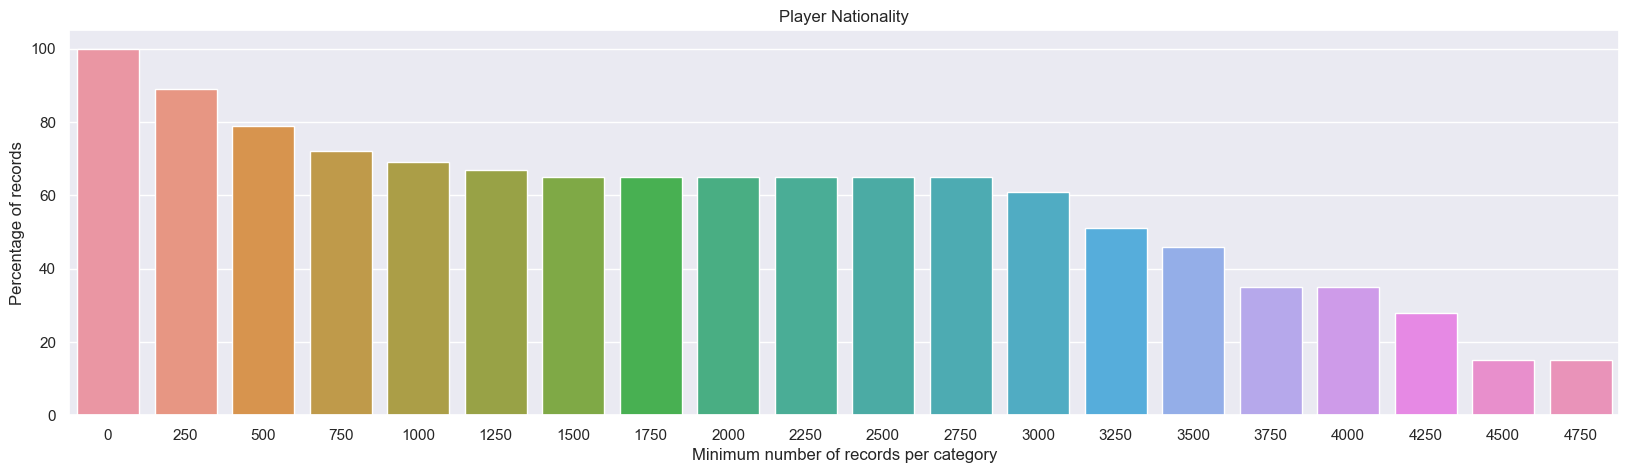

In [7]:
valueCounts = dfFootballMLBench.player_nationality.value_counts()

top_n = []
freq = []

# Check all possible cases stating from 0 records to 5000 records with step 250
for i in range(0, 5000, 250):
    
    top_n.append(i)
    freq.append(round(valueCounts[valueCounts > i].sum() / valueCounts.sum() * 100))

dfTopN = pd.DataFrame({'Percentage of records': freq, 'Minimum number of records per category': top_n})

sns.set(rc={"figure.figsize":(20, 5)})

sns.barplot(x=dfTopN['Minimum number of records per category'], y=dfTopN['Percentage of records'])\
    .set(title='Player Nationality')

In [8]:
print(f'Number of categories left is {len(valueCounts[valueCounts > 500])} out of {len(valueCounts)}')

Number of categories left is 23 out of 171


If I pick the minimum frequency as 500 I will cover 80% of data and reduce the number of categories by more than 7 times.

In [9]:
# Set One Hot Encoder with min frequency 500
ohe = OneHotEncoder(handle_unknown='ignore', min_frequency=500, drop='first')

encoded = ohe.fit_transform(dfFootballMLBench[['player_nationality']])

# Remove infrequent categories 
sInfreq = set(ohe.infrequent_categories_[0])
sAll = set(dfFootballMLBench.player_nationality.unique())
sFreq = list(sAll.difference(sInfreq))

dfOHE = pd.DataFrame(encoded.toarray(), columns=sFreq)

# Concatenate new set of features to the original data frame and drop Hotel_Name
dfFootballML = pd.concat([dfFootballML, dfOHE], axis=1)

# Remove from the bench
dfFootballMLBench = dfFootballMLBench.drop('player_nationality', axis=1)

In [14]:
dfFootballML

,player_age,player_height,games_minutes,substitutes_in,substitutes_out,substitutes_bench,shots_on,goals_total,goals_assists,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_won,dribbles_success,fouls_drawn,fouls_committed,cards_yellow,cards_yellowred,cards_red,penalty_won,penalty_missed,venue_capacity,venue_surface,Belgium,Denmark,Spain,Morocco,Serbia,Nigeria,France,Côte d'Ivoire,England,Türkiye,Cameroon,Turkey,Ghana,Italy,Netherlands,Senegal,Germany,Sweden,Argentina,Brazil,Croatia,Portugal,Ukraine,games_position
0,37.0,189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001906
1,35.0,178,314.0,3.0,4.0,5.0,1.0,0.0,1.0,144.0,6.0,18.0,4.0,0.0,0.0,15.0,7.0,4.0,7.0,1.0,0.0,0.0,0.0,0.0,50083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.247540
2,33.0,173,11.0,2.0,0.0,29.0,0.0,0.0,0.0,20.0,1.0,14.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503476
3,20.0,180,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.247540
4,20.0,180,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.126463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65856,33.0,187,56.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12139,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.126463
65857,35.0,189,44.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12139,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.126463
65858,38.0,183,339.0,4.0,4.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,12139,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.247540
65859,31.0,177,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12139,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.247540


## Ordinal encoding

### Game position

I will convert the game position to numbers based on the average goals scored.

In [12]:
# Create mapping for each position with average goals scored
mapping = pd.concat([dfFootballMLBench[['games_position']], dfFootballML[['goals_total']]], axis=1).groupby('games_position')\
    .mean('goals_total').to_dict()['goals_total']

# Apply mapping
mapped_data = dfFootballMLBench['games_position'].map(mapping)

# Merge the result to the data frame
dfFootballML = pd.concat([dfFootballML, mapped_data], axis=1)

# Remove from the bench
dfFootballMLBench = dfFootballMLBench.drop('games_position', axis=1)

# Modeling

I will try to use differnet models, features, approaches. I will start building from the basic to more advanced.

In [222]:
dfModelSummary

""
Number of features
Scaling
Feature enginnering
Hyper-parameters tuning
Feature selection
Train score
Test score
Learning time
Prediction time
Other changes


## Dummy regressor

Very simple model justs to create a baseline.

### 0th iteration

Run the model

In [15]:
# Build the model
DummyRegressionModel = model(DummyRegressor(strategy="quantile", quantile=0.5), dfFootballML, None)

# Fit the model
DummyRegressionModel.fit()

# Predict based on the model
DummyRegressionModel.predict()

Evaluate the results

In [16]:
print(f'Train score: {DummyRegressionModel.score("train")}')
print(f'Test score: {DummyRegressionModel.score("test")}')

Train score: -0.2004
Test score: -0.1943


#### Conclusion

> - The model is very basic and can't even be used as a base one. I will use a Linear Regression as a base model.

## Linear regression

### 1st iteration

The initial run.

In [20]:
# Build the model
LinearRegressionModel = model(LinearRegression(), dfFootballML, None)

# Fit the model
LinearRegressionModel.fit()

# Predict based on the model
LinearRegressionModel.predict()

# Save the results
LinearRegressionModel.save('Linear regression', '1.0', scale='-', featureE='-', hyper='-', featureS='-')

Evaluate the results

In [21]:
dfModelSummary

,Linear regression 1.0
Number of features,49
Scaling,-
Feature enginnering,-
Hyper-parameters tuning,-
Feature selection,-
Train score,0.6476
Test score,0.6513
Learning time,0.0593
Prediction time,0.0073
Other changes,NaN


#### Conclusion

> - The very first run, nothing to compare with.
> - The model explains at least 62% of the data. Not bad, let's try to improve it.

### 2nd iteration
#### KBest

Let's apply feature selection. I will use K best for that. I will be able to find the best features and cross-validate to find the best set of features.

First of all, let's compare the features in terms of scores.

[Text(0.5, 1.0, 'Features scores comparison')]

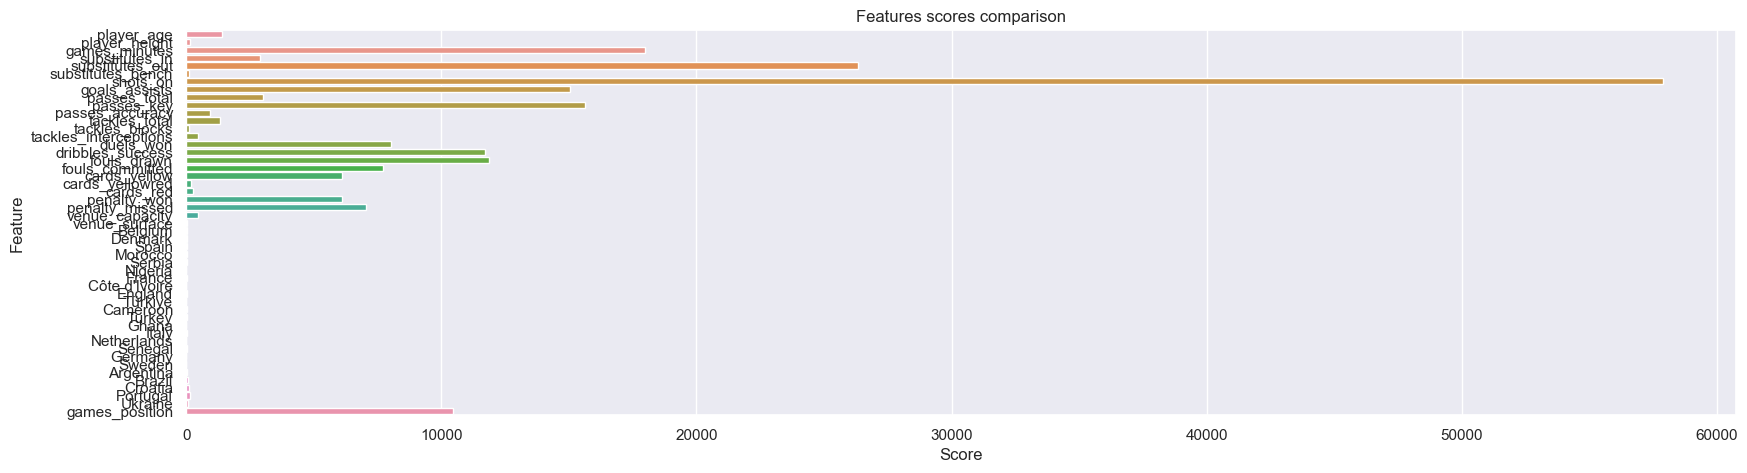

In [22]:
X = dfFootballML.drop('goals_total', axis=1)

y = dfFootballML.goals_total

KBest = SelectKBest(f_regression).fit(X, y)

dfKBest = pd.DataFrame({'Score': KBest.scores_, 'Feature': X.columns.to_list()})

sns.barplot(x=dfKBest.Score, y=dfKBest.Feature).set(title='Features scores comparison')

We can distinguish between low and high-performing features. As you can see, there are a lot of features with low scores. Now I will perform a cross-validation to find how many of the best will return the best score.

[Text(0.5, 1.0, 'Score cross-validation based on K best features')]

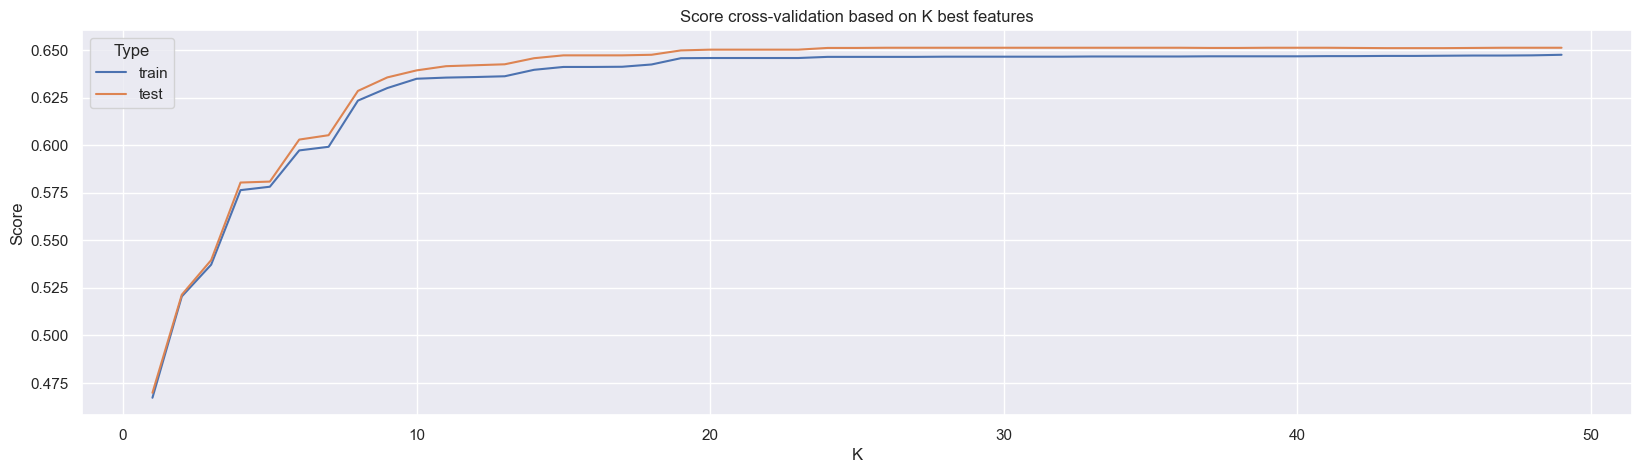

In [23]:
listScore = []
listType = []
listK = []

for i in range(len(X.columns)):
    
    KBest = SelectKBest(f_regression, k=i+1).fit(X, y)
    Xnew = X.columns[KBest.get_support()].to_list()
    Xnew.append('goals_total')
    
    # Build the model
    LinearRegressionModel = model(LinearRegression(), dfFootballML[Xnew], None)

    # Fit the model
    LinearRegressionModel.fit()

    # Predict based on the model
    LinearRegressionModel.predict()
    
    # Save the results for plotting
    listScore.append(LinearRegressionModel.score('train'))
    listType.append('train')
    listK.append(i+1)
    listScore.append(LinearRegressionModel.score('test'))
    listType.append('test')
    listK.append(i+1)

# Define the data frame for plotting
dfTempLinePlot = pd.DataFrame({'K': listK, 'Score': listScore, 'Type': listType})

# Plot the results
sns.lineplot(x=dfTempLinePlot.K, y=dfTempLinePlot.Score, hue=dfTempLinePlot.Type)\
    .set(title='Score cross-validation based on K best features')

The best result was produced with the maximum number of features.

In [229]:
# Build the model
LinearRegressionModel = model(LinearRegression(), dfFootballML, None)

# Fit the model
LinearRegressionModel.fit()

# Predict based on the model
LinearRegressionModel.predict()

# Save the results
LinearRegressionModel.save('Linear regression', '1.1', '-', '-', '-', 'KBest')

Evaluate the results

In [230]:
dfModelSummary

,Linear regression 1.0,Linear regression 1.1
Number of features,24.0,24.0
Scaling,-,-
Feature enginnering,-,-
Hyper-parameters tuning,-,-
Feature selection,-,KBest
Train score,0.6261,0.6261
Test score,0.6316,0.6316
Learning time,0.01,0.0128
Prediction time,0.003,0.0029
Other changes,NaN,NaN


#### Conclusion:

> - The result is the same, as to get the best score we need to use all features.

### 3rd iteration
#### Multivariate Feature Selection

### 4th iteration
#### Regularization

### 5th iteration
#### PCA

### 6th iteration

I will perform the scaling of the features to improve the result.

Define the summary parameters

Run the model

In [26]:
# Build the model
LinearRegressionModel = model(LinearRegression(), dfFootballML, StandardScaler())

# Fit the model
LinearRegressionModel.fit()

# Predict based on the model
LinearRegressionModel.predict()

# Save the results
LinearRegressionModel.save('Linear regression', '1.5', 'Yes', '-', '-', '-')

Evaluate the results

In [27]:
dfModelSummary

,Linear regression 1.0,Linear regression 1.2,Linear regression 1.5
Number of features,49,NaN,49.0
Scaling,-,NaN,Yes
Feature enginnering,-,NaN,-
Hyper-parameters tuning,-,NaN,-
Feature selection,-,NaN,-
Train score,0.6476,NaN,0.6476
Test score,0.6513,NaN,0.6513
Learning time,0.0593,NaN,0.0353
Prediction time,0.0073,NaN,0.0032
Other changes,NaN,NaN,NaN


#### Conclusion

> - I tried to apply scaling but it returned the same result. Hence we do not need to use scaling for this model.

## SGD regression

### 1st iteration

I will run the regressor with the default parameters.

Define the summary parameters

In [145]:
modelSummary = 'SGD regression'

modelVersion = '2.0'

dfModelSummary.loc['number of features',modelSummary + ' ' + modelVersion] = dfFootballML.shape[1] - 1

dfModelSummary.loc['scaling',modelSummary + ' ' + modelVersion] = '-'

dfModelSummary.loc['transformation',modelSummary + ' ' + modelVersion] = '-'

dfModelSummary.loc['hyper-parameters tuning',modelSummary + ' ' + modelVersion] = '-'

Run the model

In [146]:
# Build the model
SGDRegressionModel = model(SGDRegressor(), dfFootballML, True)

# Fit the model
SGDRegressionModel.fit()

# Predict based on the model
SGDRegressionModel.predict()

# Save the results
SGDRegressionModel.save(modelSummary + ' ' + modelVersion)

Evaluate the results

In [147]:
dfModelSummary

,Linear regression 1.0,Linear regression 1.1,Linear regression 1.2,SGD regression 2.0
number of features,24.0,18.0,18.0,18.0
scaling,-,-,Yes,-
transformation,-,-,-,-
hyper-parameters tuning,-,-,-,-
train score,0.6261,0.6211,0.6211,0.6166
test score,0.6316,0.6264,0.6264,0.623
learning time,0.0289,0.0094,0.0126,0.0587
prediction time,0.0036,0.0022,0.0007,0.0017
other changes,NaN,NaN,NaN,NaN


#### Conclusion

> - I got the same results as the linear model. However, this model supports hyper-parameters tunning. Let's apply them.

## KNN regressor

## Decision tree regressor

## Random forest

## SVN

## players/teams with a top/lowest number of goals scored/conceded in a single season

## compare leagues/seasons for total number of goals 

## Add the same set of features for each player but grouped for the team


# Other

In [83]:
df1 = pd.concat([dfFootballML[['goals_total']],dfFootballMLBench[['player_age']]**2], axis=1)

df1.corr()

,goals_total,player_age
goals_total,1.000000,0.137204
player_age,0.137204,1.000000


<AxesSubplot:xlabel='player_age', ylabel='goals_total'>

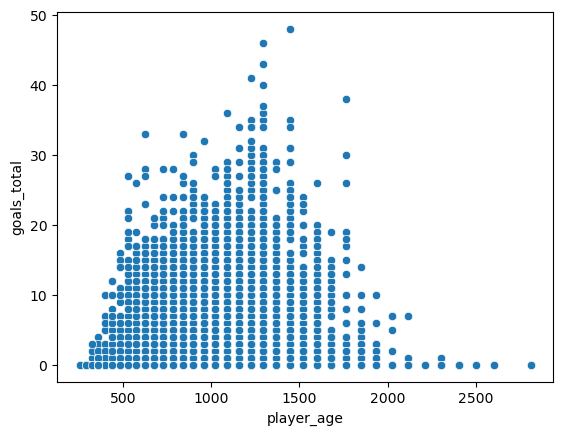

In [75]:
sns.scatterplot(y=dfFootballML['goals_total'],x=dfFootballMLBench['player_age']**2)

In [72]:
np.sqrt(dfFootballMLBench['player_age'])

0        6.082763
1        5.916080
2        5.744563
3        4.472136
4        4.472136
           ...   
65856    5.744563
65857    5.916080
65858    6.164414
65859    5.567764
65860    5.916080
Name: player_age, Length: 65861, dtype: float64

In [6]:
y = dfFootballML['goals_total']

# Define the features
X = dfFootballML.drop(['goals_total'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [47]:
df = pd.DataFrame({'X':[1,2,3,4,5], 'y':[2,2,3,3,4]})

X = df.drop('y', axis=1)

y = df['y']

X

df

,X,y
0,1,2
1,2,2
2,3,3
3,4,3
4,5,4


In [48]:
from sklearn.linear_model import LogisticRegression

# no scaling
model1 = LinearRegression()
# model1 = LogisticRegression()

model1.fit(X, y)

print(model1.score(X, y))
print(model1.coef_)

0.8928571428571428
[0.5]


In [110]:
model1.coef_

array([0.5])

In [38]:

# scaling
model2 = LinearRegression()
# model2 = LogisticRegression()

scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
# X_scaled_test = scaler.transform(X_test)

model2_fit = model2.fit(X_scaled, y)

print(model2_fit.score(X_scaled, y))
print(model2.coef_)

0.8928571428571429
[0.70710678]


In [63]:
pd.DataFrame(X_scaled)[0]

0   -1.414214
1   -0.707107
2    0.000000
3    0.707107
4    1.414214
Name: 0, dtype: float64

<AxesSubplot:xlabel='X', ylabel='y'>

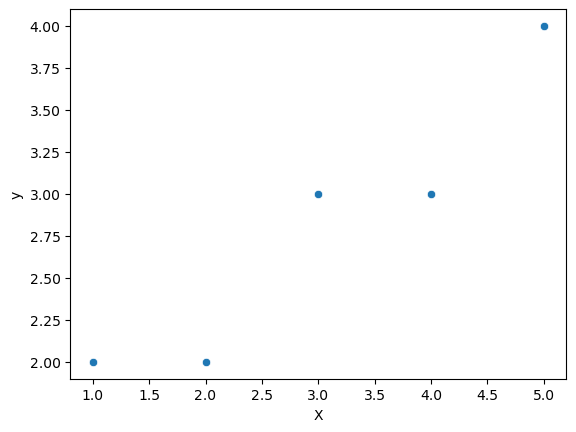

In [58]:
sns.scatterplot(data=df,x='X',y='y')

<AxesSubplot:xlabel='0', ylabel='y'>

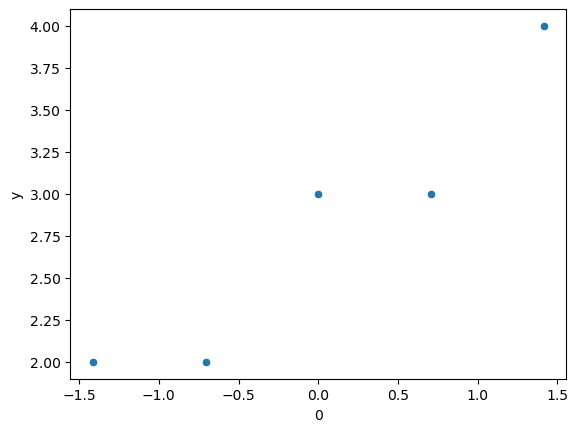

In [64]:
sns.scatterplot(x=pd.DataFrame(X_scaled)[0],y=df['y'])

In [19]:
[0,3,4,5,8,9,15,22,23,30,35,40]

[0, 3, 4, 5, 8, 9, 15, 22, 23, 30]

In [23]:
np.ediff1d([0, 3, 4, 6, 7, 8, 9, 15, 22, 23, 30, ])

array([3, 1, 1, 3, 1, 6, 7, 1, 7])

3
4
6
7
8
15
22
23
30
-1


['0', '3->4', '6->8', '15', '22->23', '30']